# 卷积的实现

## 大纲





### 回忆卷积计算
- 维度
  - 输入层：batch_size * channel输入维数 * height * width（B*C*H*W）
  `float Z[BATCHES][HEIGHT][WIDTH][CHANNELS];`
  - 上述格式被称为**NHWC**格式，N为batch数量，不同顺序会导致性能差异：卷积在NHWC上更快，Batch Norm在NCHW上更快（pytorch默认格式为NCHW）
  - 卷积层（核）：k * k * C_in * C_out
  `float weights[KERNEL_SIZE][KERNEL_SIZE][IN_CHANNELS][OUT_CHANNELS];`
  - pytorch默认格式为(C_out, C_in, k, k)

### 卷积实践
#### pytorch版

In [50]:
import torch
import torch.nn as nn
import numpy as np

# Z为输入层，weight为卷积核
def conv_reference(Z,weight):
    # NHWC维度需要转变成NCHW,用于pytorch运算
    Z_torch = torch.tensor(Z).permute(0,3,1,2)

    # weight也需要，KKIO to OIKK
    W_torch = torch.tensor(weight).permute(3,2,0,1)

    out = nn.functional.conv2d(Z_torch,W_torch)
    # 结果转换回原格式,contiguous函数保证经过维度顺序改变后的数组在内存中为连续存储的
    return out.permute(0,2,3,1).contiguous().numpy()

In [ ]:
Z = np.random.randn(10,32,32,8)
W = np.random.randn(3,3,8,16)
out = conv_reference(Z,W)
out.shape

(10, 30, 30, 16)

#### for循环版

In [52]:
# 卷积操作的低效做法，只用for
def conv_naive(Z, weight):
    N,H,W,C_in = Z.shape
    K,_,_,C_out = weight.shape
    out = np.zeros((N,H-K+1,W-K+1,C_out))

    for n in range(N):
        for c_in in range(C_in):
            for c_out in range(C_out):
                for y in range(H-K+1):
                    for x in range(W-K+1):
                        for i in range(K):
                            for j in range(K):
                                # out[n][y][x][c_out] += Z[n][y+i][x+j][c_in] * weight[i][j][c_in][c_out]
                                # 注释代码访问方式更低效，而用逗号分隔一次就能访问内存内容较快
                                out[n,y,x,c_out] += Z[n,y+i,x+j,c_in] * weight[i,j,c_in,c_out]

    return out

In [53]:
out2 = conv_naive(Z,W)
print(np.linalg.norm(out-out2))
# 约为0

1.2402546982131154e-12


- 运行时间对比

In [54]:
%%time
out2 = conv_naive(Z,W)

CPU times: total: 5.05 s
Wall time: 5.27 s


In [55]:
%%timeit
out = conv_reference(Z,W)
# so fast!

342 μs ± 2.95 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


#### 矩阵乘法版

In [56]:
# 卷积核中k * k的长宽矩阵中每个元素都是一个小矩阵（cin * cout）,可以认为是输入层(:,:,:,c_in) @ (:,:,c_in,c_out)得出的结果层
W1 = np.random.randn(1,1,8,16)
out = conv_reference(Z,W1)
out2 = Z @ W1[0,0]
# 等价于此
# out3 = (Z.reshape(-1,8) @ W1[0,0]).reshape(10,32,32,16)
np.linalg.norm(out - out2)

1.3103891253286745e-13

怎么拓展到k*k呢？
> 通过切片提取局部输入层窗口并与卷积核对应位置的权重（cin*cout）进行矩阵乘法

In [57]:
def conv_matrix_mult(Z, weight):
    N,H,W,C_in = Z.shape
    K,_,_,C_out = weight.shape
    out = np.zeros((N,H-K+1,W-K+1,C_out))
    for i in range(K):
        for j in range(K):
            # 对Z切片的本质是模拟卷积的滑动窗口
            # 每个窗口对应卷积核位置 (i, j) 在输入上的所有可能覆盖区域
            out += Z[:,i:i+H-K+1,j:j+W-K+1,:] @ weight[i,j]
    
    return out

- 我的理解是：
    - 本来是result[0][0] = 红色区域内输入层对应块于卷积核对应块的乘积的和，以此类推...
  
      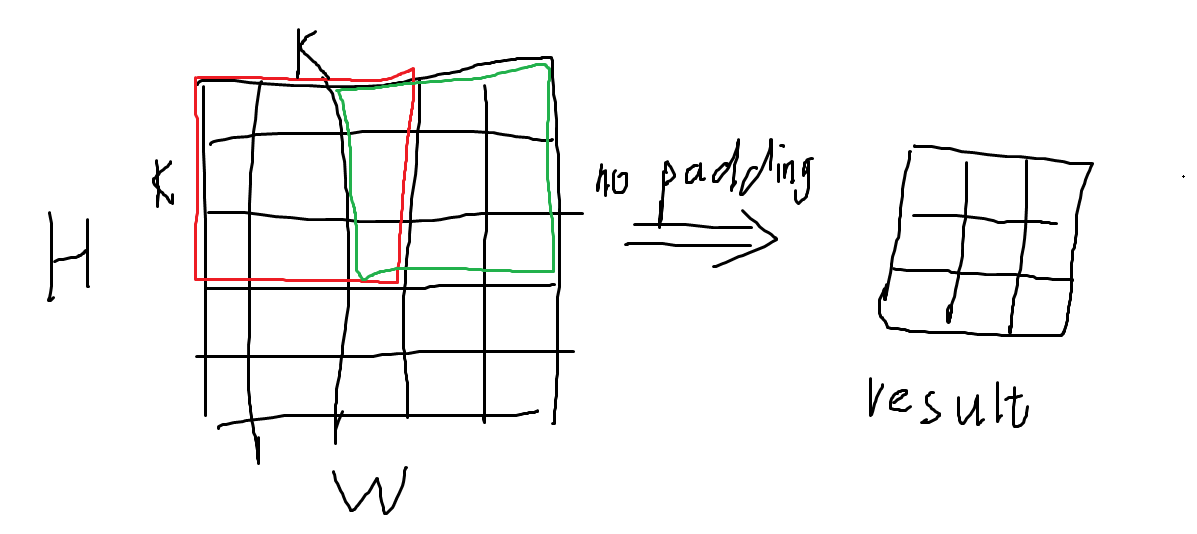
    - 这里的理解是`Z[:,i:i+H-K+1,j:j+W-K+1,:]`中间的切片代表`weight[i][j]`在整个卷积滑动过程中的一个范围，大小于输出层的`[:,H-K+1,W-K+1,:]`相同，所以就相当于在输出层out的每个小块先分别加上输入层中切片的对应小块与`weight[0][0]`的乘积，再`weight[0][1]`...
  
      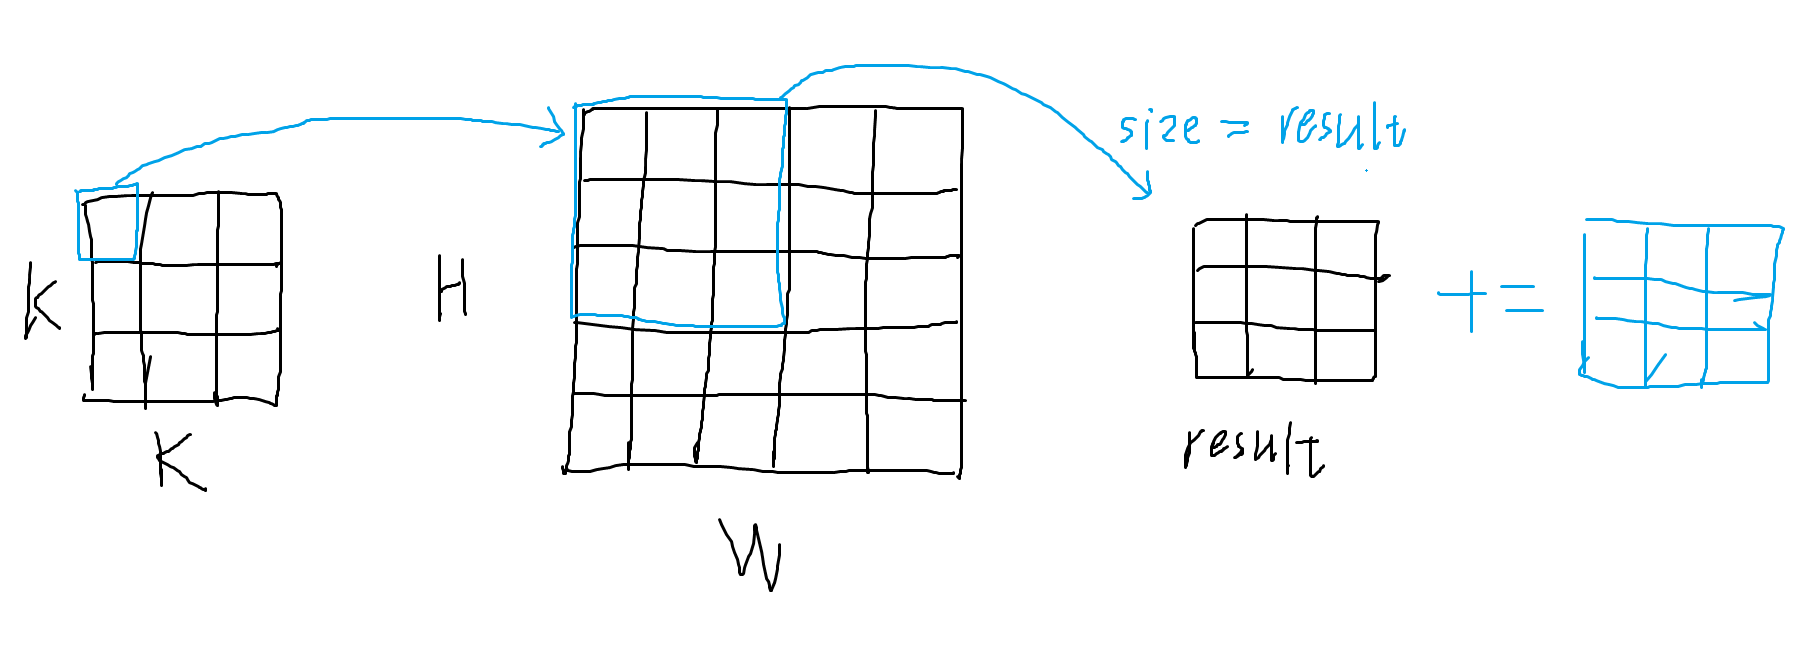

In [58]:
out = conv_reference(Z,W)
out2 = conv_matrix_mult(Z,W)
np.linalg.norm(out - out2)

1.083502071057792e-12

- 通过strides操作矩阵

In [59]:
n = 6
A = np.arange(n**2, dtype=np.float32).reshape(n,n)
A

array([[ 0.,  1.,  2.,  3.,  4.,  5.],
       [ 6.,  7.,  8.,  9., 10., 11.],
       [12., 13., 14., 15., 16., 17.],
       [18., 19., 20., 21., 22., 23.],
       [24., 25., 26., 27., 28., 29.],
       [30., 31., 32., 33., 34., 35.]], dtype=float32)

In [60]:
import ctypes
# 内部存储数据的模式
print(np.frombuffer(ctypes.string_at(A.ctypes.data, A.nbytes),dtype = A.dtype, count = A.size))
A.strides # .strides表示沿着数组的某个维度移动时，需要跨过多少字节的内存地址才能到达下一个元素

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.]


(24, 4)

怎么将原矩阵(M, N)reshape为(M/TILE, TILE, N/TILE, TILE) ？

In [61]:
A.reshape(3,3,2,2)
# reshape只能横向分组，而不是将矩阵分块（假设分的小块为2 * 2，则第一块应该是0，1，6，7）

array([[[[ 0.,  1.],
         [ 2.,  3.]],

        [[ 4.,  5.],
         [ 6.,  7.]],

        [[ 8.,  9.],
         [10., 11.]]],


       [[[12., 13.],
         [14., 15.]],

        [[16., 17.],
         [18., 19.]],

        [[20., 21.],
         [22., 23.]]],


       [[[24., 25.],
         [26., 27.]],

        [[28., 29.],
         [30., 31.]],

        [[32., 33.],
         [34., 35.]]]], dtype=float32)

In [62]:
B = np.lib.stride_tricks.as_strided(A, shape=(3,3,2,2), strides=np.array((12,2,6,1))*4)  #numpy中strides以字节为单位
# strides = np.array((strides[0] = 从一个子矩阵移动到同列下一个子矩阵对应位置的步长,strides[1] = 从一个子矩阵移动到同行下一个子矩阵的对应位置的步长,strides[2] = 在子矩阵中移动到下一行元素的步长,strides[3] = 在子矩阵内部移动到下一列的元素的步长))
# 相当于你想要stride的目标n维数组，每个维度的元素之间的内存步长（以字节为单位的实际步长），故要由这里的逻辑步长*4 = float32的实际四个字节为一元素
B

array([[[[ 0.,  1.],
         [ 6.,  7.]],

        [[ 2.,  3.],
         [ 8.,  9.]],

        [[ 4.,  5.],
         [10., 11.]]],


       [[[12., 13.],
         [18., 19.]],

        [[14., 15.],
         [20., 21.]],

        [[16., 17.],
         [22., 23.]]],


       [[[24., 25.],
         [30., 31.]],

        [[26., 27.],
         [32., 33.]],

        [[28., 29.],
         [34., 35.]]]], dtype=float32)

`np.lib.stride_tricks.as_strided()`不改变底层内存数据，仅仅改变数组视图，如果需要改变内存数据排列情况变成连续来加速运算，则需要用`np.ascontiguousarray()`函数（返回一个连续的副本，不改变原数组内存）

In [63]:
print(np.frombuffer(ctypes.string_at(B.ctypes.data, B.nbytes),dtype = B.dtype, count = B.size))
C = np.ascontiguousarray(B)
print(np.frombuffer(ctypes.string_at(C.ctypes.data, C.nbytes),dtype = C.dtype, count = C.size))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.]
[ 0.  1.  6.  7.  2.  3.  8.  9.  4.  5. 10. 11. 12. 13. 18. 19. 14. 15.
 20. 21. 16. 17. 22. 23. 24. 25. 30. 31. 26. 27. 32. 33. 28. 29. 34. 35.]


#### im2col版

- 回忆一下之前讲过的一维的im2col

- $\left[\begin{array}{c}
z_1 \\
z_2 \\
z_3 \\
z_4 \\
z_5
\end{array}\right]=x * w=\left[\begin{array}{ccc}
0 & x_1 & x_2 \\
x_1 & x_2 & x_3 \\
x_2 & x_3 & x_4 \\
x_3 & x_4 & x_5 \\
x_4 & x_5 & 0
\end{array}\right]\left[\begin{array}{l}
w_1 \\
w_2 \\
w_3
\end{array}\right]$
                          
- $\left[\begin{array}{ccc}
0 & x_1 & x_2 \\
x_1 & x_2 & x_3 \\
x_2 & x_3 & x_4 \\
x_3 & x_4 & x_5 \\
x_4 & x_5 & 0
\end{array}\right]$ 为**感受野**

- 将输入层更改格式以适用于直接的矩阵乘法，在此输入层和卷积核都是二维的故需要将输入层变成`(H-K+1) * (W-K+1) * K * K`的形式（暂且忽略N,C），这样才方便与卷积核相乘


In [70]:
W = np.arange(9,dtype=np.float64).reshape(3,3) # weight
W

array([[0., 1., 2.],
       [3., 4., 5.],
       [6., 7., 8.]])

In [71]:
B = np.lib.stride_tricks.as_strided(A, shape=(4,4,3,3), strides=np.array((6,1,6,1))*4) # 将输入层变成4 * 4 * 3 * 3的形式
B

array([[[[ 0.,  1.,  2.],
         [ 6.,  7.,  8.],
         [12., 13., 14.]],

        [[ 1.,  2.,  3.],
         [ 7.,  8.,  9.],
         [13., 14., 15.]],

        [[ 2.,  3.,  4.],
         [ 8.,  9., 10.],
         [14., 15., 16.]],

        [[ 3.,  4.,  5.],
         [ 9., 10., 11.],
         [15., 16., 17.]]],


       [[[ 6.,  7.,  8.],
         [12., 13., 14.],
         [18., 19., 20.]],

        [[ 7.,  8.,  9.],
         [13., 14., 15.],
         [19., 20., 21.]],

        [[ 8.,  9., 10.],
         [14., 15., 16.],
         [20., 21., 22.]],

        [[ 9., 10., 11.],
         [15., 16., 17.],
         [21., 22., 23.]]],


       [[[12., 13., 14.],
         [18., 19., 20.],
         [24., 25., 26.]],

        [[13., 14., 15.],
         [19., 20., 21.],
         [25., 26., 27.]],

        [[14., 15., 16.],
         [20., 21., 22.],
         [26., 27., 28.]],

        [[15., 16., 17.],
         [21., 22., 23.],
         [27., 28., 29.]]],


       [[[18., 19., 20.],
        

- 但是即使这样，如果B的一个小矩阵直接和W相乘，只能得到一个矩阵而不是像上述一维的矩阵乘积那样得到一个值，能不能变成以上一维的情况，即将这每个小矩阵变成一行 & 将W变成一列呢？
- 发现将每个小矩阵变成一行，即3 * 3的矩阵要变成列数为9，一共有4 * 4 = 16个地方需要乘积，故行数为16，即用reshape得到下述代码

In [72]:
out = (B.reshape(16,9) @ W.reshape(9)).reshape(4,4)
out

array([[ 366.,  402.,  438.,  474.],
       [ 582.,  618.,  654.,  690.],
       [ 798.,  834.,  870.,  906.],
       [1014., 1050., 1086., 1122.]])

> 注意，B的reshape的操作并不是free的，无法通过原始A的数据来表示reshape后的B,reshape 操作会触发以下行为：
> - 内存复制：NumPy 必须将每个窗口的K * K元素复制到连续的内存块中
> - 每个窗口需要`K**2`个元素的空间,若有M个窗口,总内存为`M*(K**2)*元素字节数`

In [81]:
# im2col版的整体函数
def conv_im2col(Z, weight):
    N,H,W,C_in = Z.shape
    K,_,_,C_out = weight.shape
    Ns, Hs, Ws, Cs = Z.strides # 没想到
    
    inner_dim = K * K * C_in
    # A的strides实际上和输入层Z相同，reshape之后才不同
    # 一开始想的是仍然用for遍历其他维度，但是可以直接扩充升维
    A = np.lib.stride_tricks.as_strided(Z, shape = (N, H-K+1, W-K+1, K, K, C_in),
                                        strides = (Ns, Hs, Ws, Hs, Ws, Cs)).reshape(-1,inner_dim) # reshape中-1表示自动计算维度
    out = A @ weight.reshape(inner_dim, C_out)
    return out.reshape(N,H-K+1,W-K+1,C_out)

- 添加了N和C_in维度，但是最后的@形式仍然要和前面一维的例子相同，故需要再将矩阵展开
- 我的理解是再加多少维度也是一样，最终都是先计算出滑动卷积核有多少个窗口（窗口大小为$ K \times K \times C_{in} $，总共有 $ N \times (H-K+1) \times (W-K+1) $ 个窗口），再将各窗口展开为二维的矩阵，形状为$ \left( N \times (H-K+1) \times (W-K+1), \ K \times K \times C_{in} \right) $ （每个窗口变成一个行向量，包含 $ K \times K \times C_{in} $ 个元素）
- 卷积核之前是一个列向量，但是因为新增输出通道数维度，故需要按输出通道数分成每个输出通道的权重变成一个列向量，包含所有 $ K \times K \times C_{in} $ 个权重
- 这样就按照前面一维的乘法乘积即可

In [82]:
W = np.random.randn(3,3,8,16)
out = conv_reference(Z,W)
out2 = conv_im2col(Z,W)
np.linalg.norm(out - out2)

6.721646949466347e-13

- 运行时间

In [83]:
%%timeit
out2 = conv_im2col(Z,W)

1.76 ms ± 15.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
